In [11]:
%pip install kmodes
%pip install yellowbrick
%pip install kneed
%pip install fuzzy-c-means

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
# Make imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import datasets
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import seaborn as sns
import pyclustertend
import random

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from kmodes.kprototypes import KPrototypes
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator

import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
datos = pd.read_csv('Fuel_Consumption_2000-2022.csv')
print(datos.head())

descripcion = datos.describe()

#Revision de valores nulos
# Chequear si hay valores nulos
nan_columns = datos.columns[datos.isna().any()].tolist()
print(nan_columns)
print(datos[datos.isna().any(axis=1)])
print(len(datos[datos.isna().any(axis=1)]))
print(len(datos))

   YEAR   MAKE    MODEL VEHICLE CLASS  ENGINE SIZE  CYLINDERS TRANSMISSION  \
0  2000  ACURA    1.6EL       COMPACT          1.6          4           A4   
1  2000  ACURA    1.6EL       COMPACT          1.6          4           M5   
2  2000  ACURA    3.2TL      MID-SIZE          3.2          6          AS5   
3  2000  ACURA    3.5RL      MID-SIZE          3.5          6           A4   
4  2000  ACURA  INTEGRA    SUBCOMPACT          1.8          4           A4   

  FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  COMB (mpg)  \
0    X               9.2             6.7              8.1          35   
1    X               8.5             6.5              7.6          37   
2    Z              12.2             7.4             10.0          28   
3    Z              13.4             9.2             11.5          25   
4    X              10.0             7.0              8.6          33   

   EMISSIONS  
0        186  
1        175  
2        230  
3        264  
4        198  
[]

#### 1. Estudia las variables cuantitativas mediante técnicas de estadística descriptiva

In [ ]:
datos = pd.read_csv('Fuel_Consumption_2000-2022.csv')
print(datos.head())

temp_descriptiva = datos.drop(['YEAR', 'MAKE', 'MODEL', 'VEHICLE CLASS', 'TRANSMISSION', 'FUEL'], axis=1)
descriptiva = temp_descriptiva.describe()

print(descriptiva)

#### 2. Gráficos exploratorios

In [ ]:
# Establecer el estilo de los gráficos
sns.set(style='whitegrid')

# 1. Relación entre consumo de combustible combinado y emisiones
plt.figure(figsize=(10, 6))
sns.scatterplot(x='COMB (L/100 km)', y='EMISSIONS', hue='VEHICLE CLASS', data=datos)
plt.title('Relación entre Consumo de Combustible Combinado y Emisiones')
plt.xlabel('Consumo de Combustible Combinado (L/100 km)')
plt.ylabel('Emisiones (g/km)')
plt.show()

Se observa que sí existe una relación de combustible combinado y emisiones, dado el gráfico, se observa que a mayor consumo de combustible hay una mayor emisión. Es interesante observar que se diferencian dos líneas principales que marcan una diferencia entre los grupos de modelos, siendo este agrupamiento por tamaño relativo.

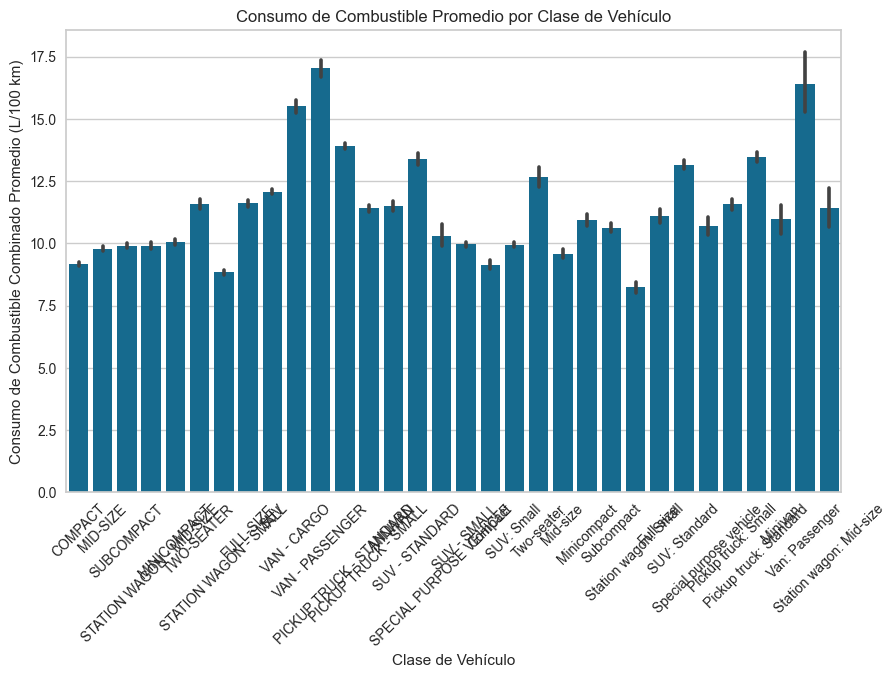

In [15]:
# 2. Consumo de combustible promedio por clase de vehículo
plt.figure(figsize=(10, 6))
sns.barplot(x='VEHICLE CLASS', y='COMB (L/100 km)', data=datos)
plt.title('Consumo de Combustible Promedio por Clase de Vehículo')
plt.xlabel('Clase de Vehículo')
plt.ylabel('Consumo de Combustible Combinado Promedio (L/100 km)')
plt.xticks(rotation=45)
plt.show()

A simple vista, podemos ver que las clases 'COMPACT', 'MID-SIZE', y 'SUBCOMPACT' tienen los consumos promedio de combustible más bajos, indicando que son más eficientes en cuanto a combustible. En contraste, las clases con barras más altas, como 'VAN - PASSENGER', 'SUV - STANDARD', y 'PICKUP TRUCK - STANDARD', muestran consumos de combustible más elevados, sugiriendo que son menos eficientes desde el punto de vista del combustible.

El gráfico también muestra que hay una gran variación dentro de algunas clases, como 'SUV - STANDARD', 'MINICOMPACT', y 'TWO-SEATER', lo cual se evidencia por las barras de error relativamente largas.

In [ ]:
# 3. Emisiones promedio por clase de vehículo
plt.figure(figsize=(10, 6))
sns.barplot(x='VEHICLE CLASS', y='EMISSIONS', data=datos)
plt.title('Emisiones Promedio por Clase de Vehículo')
plt.xlabel('Clase de Vehículo')
plt.ylabel('Emisiones Promedio (g/km)')
plt.xticks(rotation=45)
plt.show()

Podemos observar que las clases de vehículos como 'COMPACT', 'MID-SIZE' y 'SUBCOMPACT' tienden a tener las emisiones más bajas, lo que sugiere que son más amigables con el ambiente en términos de emisiones de CO2. Por otro lado, las clases 'PICKUP TRUCK - STANDARD', 'VAN - PASSENGER' y 'SUV - STANDARD' muestran las emisiones promedio más altas, lo que indica que estos vehículos son menos eficientes en términos de emisiones. Las líneas negras verticales en la parte superior de las barras representan el error estándar o la variabilidad de las emisiones dentro de cada clase de vehículo. Barras con líneas de error más largas indican una mayor variabilidad en las emisiones dentro de esa clase de vehículo.

In [ ]:
# 4. Distribución de tamaños de motor
plt.figure(figsize=(10, 6))
sns.histplot(datos['ENGINE SIZE'], bins=10, kde=True)
plt.title('Distribución de Tamaños de Motor')
plt.xlabel('Tamaño del Motor (litros)')
plt.ylabel('Frecuencia')
plt.show()

Las barras del histograma indican la cantidad de vehículos que tienen un motor de cierto tamaño, y la línea de densidad proporciona una estimación suavizada de la distribución. Observando el histograma, parece que hay picos notables en torno a motores de 2 litros, 3-3.5 litros y otro pico menos pronunciado cerca de los 4.5 litros. Además, hay una cantidad significativa de vehículos con motores más pequeños, entre 1 y 2 litros.

In [ ]:
# 5. Comparación del consumo de combustible en carretera y combinado
plt.figure(figsize=(10, 6))
data_melted = datos.melt(value_vars=['HWY (L/100 km)', 'COMB (L/100 km)'], var_name='Type', value_name='Fuel Consumption')
sns.boxplot(x='Type', y='Fuel Consumption', data=data_melted)
plt.title('Comparación del Consumo de Combustible en Carretera y Combinado')
plt.xlabel('')
plt.ylabel('Consumo de Combustible (L/100 km)')
plt.show()

De lo que podemos observar en el gráfico:
- La mediana del consumo en carretera (HWY) es más baja que la mediana del consumo combinado (COMB), lo que es de esperar, ya que generalmente los vehículos son más eficientes en carretera que en un escenario combinado de carretera y ciudad.
- La distribución del consumo en carretera es más estrecha (la caja es más corta), lo que sugiere que los valores son menos dispersos en comparación con el consumo combinado.
- Hay muchos valores atípicos tanto para el consumo en carretera como para el consumo combinado, indicando que hay algunos vehículos que son mucho menos eficientes que la mayoría.
- La caja del consumo combinado es más larga, lo que indica una mayor variabilidad en el consumo de combustible en esta categoría.

Tabla de frecuencia para YEAR:
2015    1132
2016    1110
2009    1092
2018    1083
2012    1081
2008    1079
2011    1076
2017    1058
2013    1058
2019    1056
2007    1043
2014    1040
2010    1021
2005    1019
2020     968
2006     968
2022     955
2021     941
2004     898
2003     820
2002     740
2001     679
2000     639
Name: YEAR, dtype: int64

Tabla de proporciones para YEAR:
2015    0.050186
2016    0.049211
2009    0.048413
2018    0.048014
2012    0.047925
2008    0.047836
2011    0.047703
2017    0.046905
2013    0.046905
2019    0.046817
2007    0.046240
2014    0.046107
2010    0.045265
2005    0.045176
2020    0.042915
2006    0.042915
2022    0.042339
2021    0.041718
2004    0.039812
2003    0.036354
2002    0.032807
2001    0.030103
2000    0.028329
Name: YEAR, dtype: float64



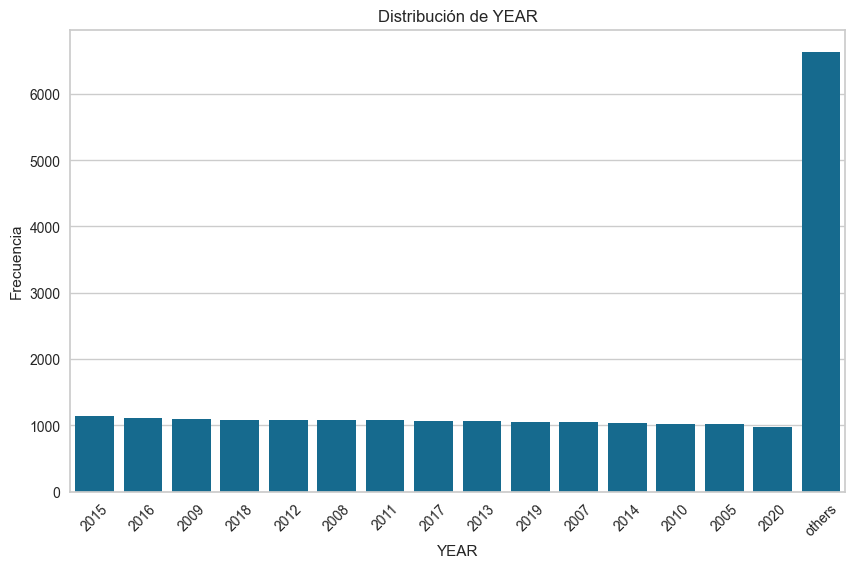

Tabla de frecuencia para MAKE:
CHEVROLET        1725
BMW              1490
GMC              1357
FORD             1276
MERCEDES-BENZ     935
                 ... 
ALFA ROMEO          8
SRT                 4
GENESIS             4
BUGATTI             3
PLYMOUTH            2
Name: MAKE, Length: 87, dtype: int64

Tabla de proporciones para MAKE:
CHEVROLET        0.076476
BMW              0.066058
GMC              0.060161
FORD             0.056570
MERCEDES-BENZ    0.041452
                   ...   
ALFA ROMEO       0.000355
SRT              0.000177
GENESIS          0.000177
BUGATTI          0.000133
PLYMOUTH         0.000089
Name: MAKE, Length: 87, dtype: float64



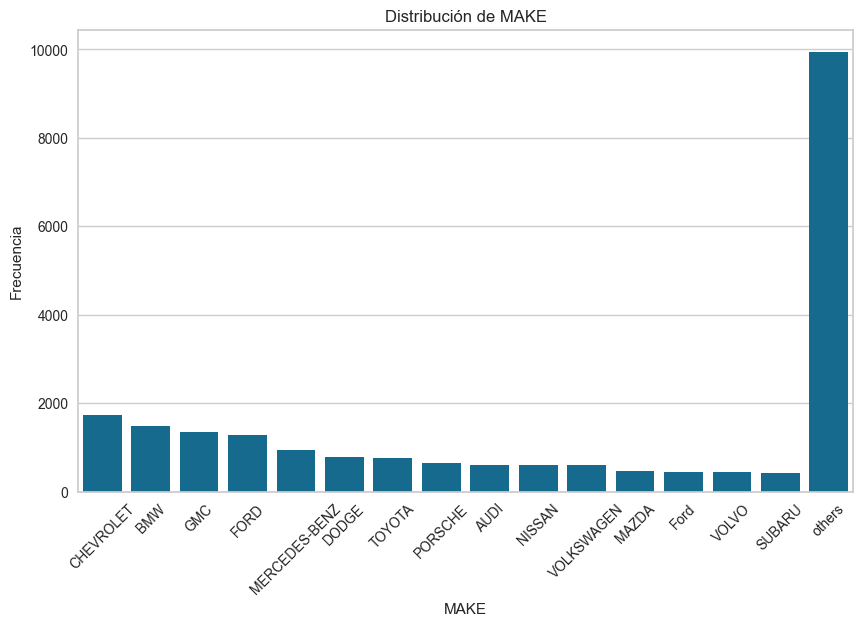

Tabla de frecuencia para VEHICLE CLASS:
SUV                         2640
COMPACT                     2636
MID-SIZE                    2300
PICKUP TRUCK - STANDARD     1689
SUBCOMPACT                  1559
FULL-SIZE                   1086
TWO-SEATER                   999
SUV: Small                   929
SUV - SMALL                  827
MINICOMPACT                  783
STATION WAGON - SMALL        737
Mid-size                     660
SUV: Standard                608
Pickup truck: Standard       515
SUV - STANDARD               514
Compact                      491
Subcompact                   451
Full-size                    417
PICKUP TRUCK - SMALL         403
MINIVAN                      366
STATION WAGON - MID-SIZE     343
VAN - CARGO                  332
Two-seater                   313
VAN - PASSENGER              287
Minicompact                  211
Station wagon: Small         140
Pickup truck: Small          108
Special purpose vehicle       62
SPECIAL PURPOSE VEHICLE       52
Sta

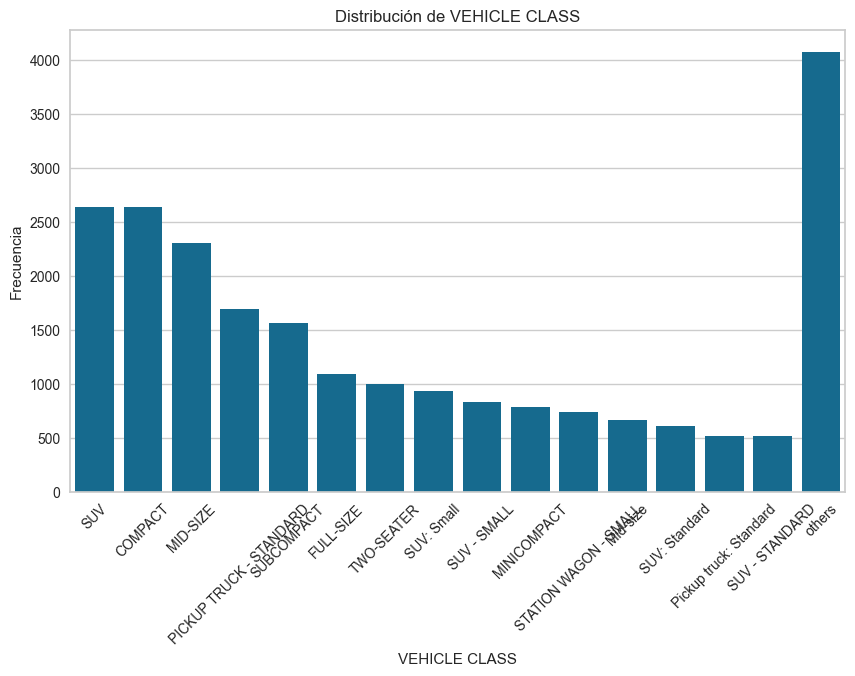

Tabla de frecuencia para ENGINE SIZE:
2.0    3020
3.0    2070
2.5    1506
3.5    1467
5.3    1230
       ... 
2.1       5
0.9       3
6.3       3
0.8       3
4.1       1
Name: ENGINE SIZE, Length: 63, dtype: int64

Tabla de proporciones para ENGINE SIZE:
2.0    0.133889
3.0    0.091772
2.5    0.066767
3.5    0.065038
5.3    0.054531
         ...   
2.1    0.000222
0.9    0.000133
6.3    0.000133
0.8    0.000133
4.1    0.000044
Name: ENGINE SIZE, Length: 63, dtype: float64



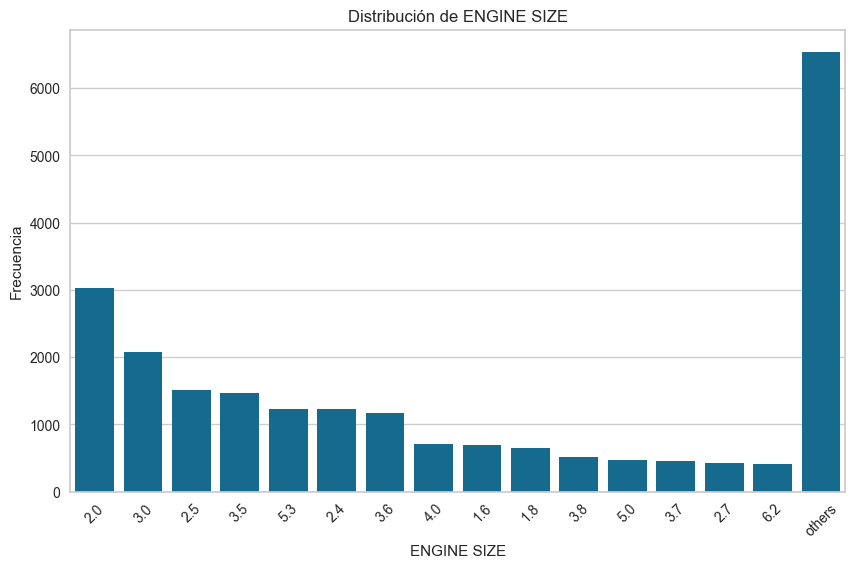

Tabla de frecuencia para CYLINDERS:
4     8049
6     8021
8     5187
5      499
12     451
10     162
3      159
2       16
16      12
Name: CYLINDERS, dtype: int64

Tabla de proporciones para CYLINDERS:
4     0.356845
6     0.355604
8     0.229961
5     0.022123
12    0.019995
10    0.007182
3     0.007049
2     0.000709
16    0.000532
Name: CYLINDERS, dtype: float64



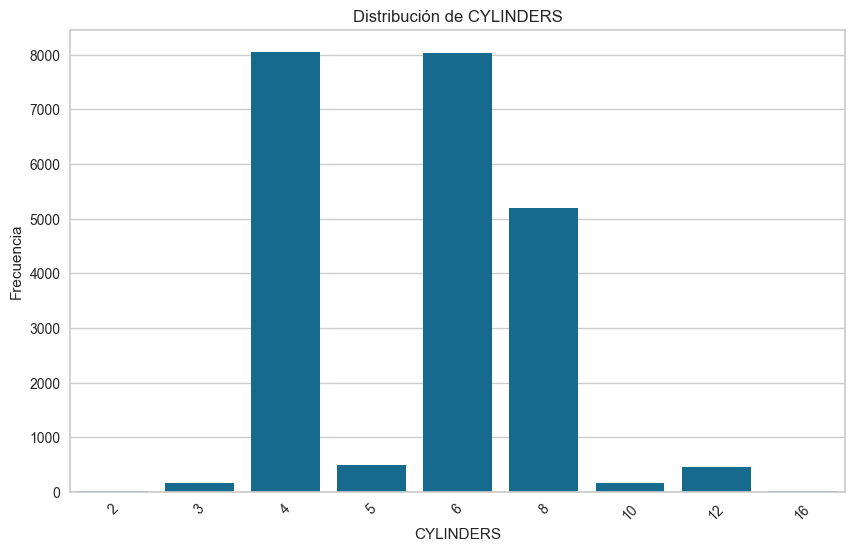

Tabla de frecuencia para TRANSMISSION:
A4      3519
AS6     2834
M6      2609
M5      2104
A6      1965
AS8     1733
A5      1420
AS5      865
AV       816
A8       794
AM7      689
AS7      614
A9       529
AS10     335
A7       278
AS4      245
AM6      214
AM8      164
A10      162
AV7      143
AV6      137
M7       130
AS9      110
AV8       78
AV10      25
A3        24
AV1        8
AM5        6
AM9        5
M4         1
Name: TRANSMISSION, dtype: int64

Tabla de proporciones para TRANSMISSION:
A4      0.156012
AS6     0.125643
M6      0.115668
M5      0.093279
A6      0.087117
AS8     0.076831
A5      0.062954
AS5     0.038349
AV      0.036177
A8      0.035201
AM7     0.030546
AS7     0.027221
A9      0.023453
AS10    0.014852
A7      0.012325
AS4     0.010862
AM6     0.009487
AM8     0.007271
A10     0.007182
AV7     0.006340
AV6     0.006074
M7      0.005763
AS9     0.004877
AV8     0.003458
AV10    0.001108
A3      0.001064
AV1     0.000355
AM5     0.000266
AM9     0.000222
M4 

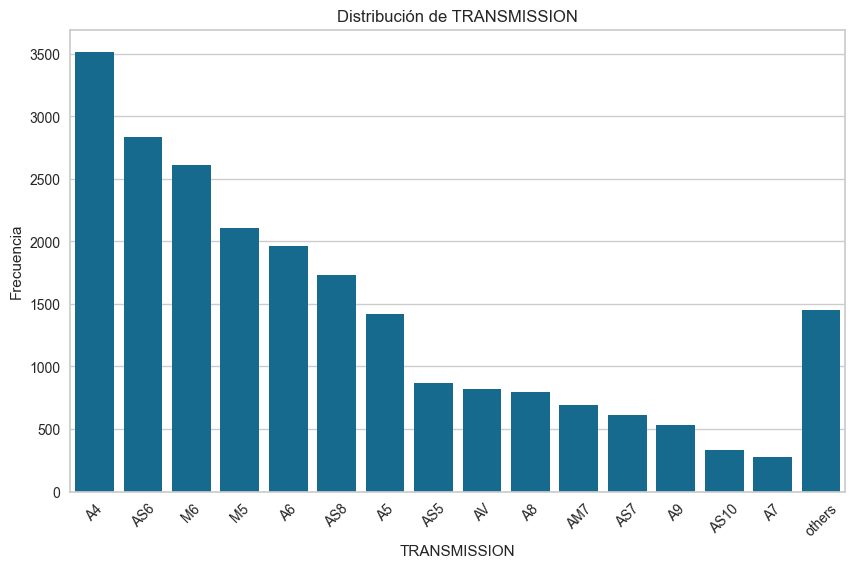

Tabla de frecuencia para FUEL:
X    11822
Z     9316
E     1071
D      314
N       33
Name: FUEL, dtype: int64

Tabla de proporciones para FUEL:
X    0.524118
Z    0.413016
E    0.047482
D    0.013921
N    0.001463
Name: FUEL, dtype: float64



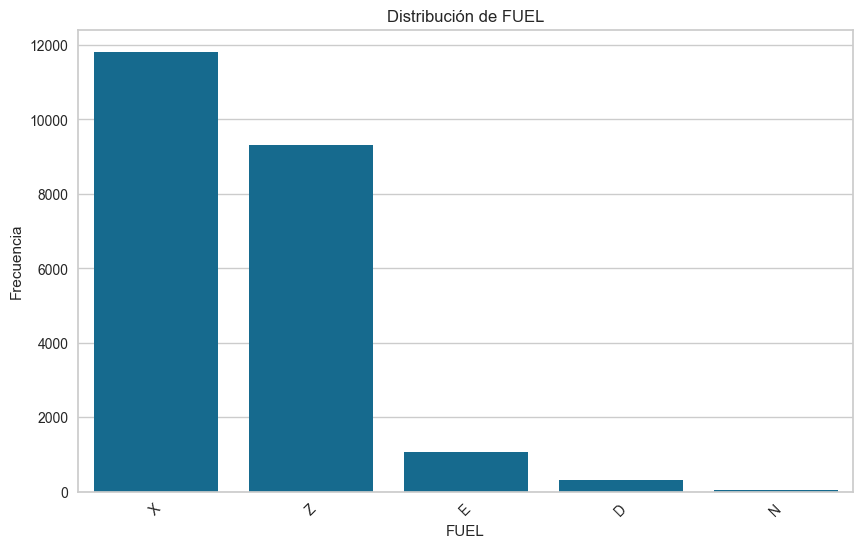

In [18]:
# Lista de variables categóricas
categorical_variables = ['YEAR','MAKE', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS','TRANSMISSION', 'FUEL']

# Para cada variable categórica
for variable in categorical_variables:
    # Tabla de frecuencia
    freq_table = datos[variable].value_counts()
    print(f'Tabla de frecuencia para {variable}:\n{freq_table}\n')

    # Tabla de proporciones
    prop_table = datos[variable].value_counts(normalize=True)
    print(f'Tabla de proporciones para {variable}:\n{prop_table}\n')

    #Si hay mas de 15 registros:
    if len(freq_table) > 15:
        # Tomar los primeros 15 registros
        top_15 = freq_table.iloc[:15]
        
        # Sumar las frecuencias del resto
        others_sum = freq_table.iloc[15:].sum()
        
        # Crear una nueva serie con los primeros 15 registros y "others"
        new_freq_table = top_15.append(pd.Series([others_sum], index=['others']))
    else:
        #Si no hay mas de 15, se queda como está
        new_freq_table = freq_table
    
    # Gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x=new_freq_table.index, y=new_freq_table.values)
    plt.title(f'Distribución de {variable}')
    plt.ylabel('Frecuencia')
    plt.xlabel(variable)
    plt.xticks(rotation=45)
    plt.show()


¿Hacemos Clustering?

In [3]:
Y = np.array(datos[['MAKE']])

columns = datos.select_dtypes(include='number').columns.to_list()
columns.remove('YEAR')
# print(columns)
X = np.array(datos[columns])
X.shape

(22556, 7)

In [25]:
print(columns)

['ENGINE SIZE', 'CYLINDERS', 'FUEL CONSUMPTION', 'HWY (L/100 km)', 'COMB (L/100 km)', 'COMB (mpg)', 'EMISSIONS']


In [17]:
random.seed(123)
X_scale=sklearn.preprocessing.scale(X)

pyclustertend.hopkins(X,len(X))

0.0027196463588275545

# Numero de grupos

Elbow Score Plot (distortion metric):
elbow value = optimal k: 5  | elbow score: 7,211,358.345


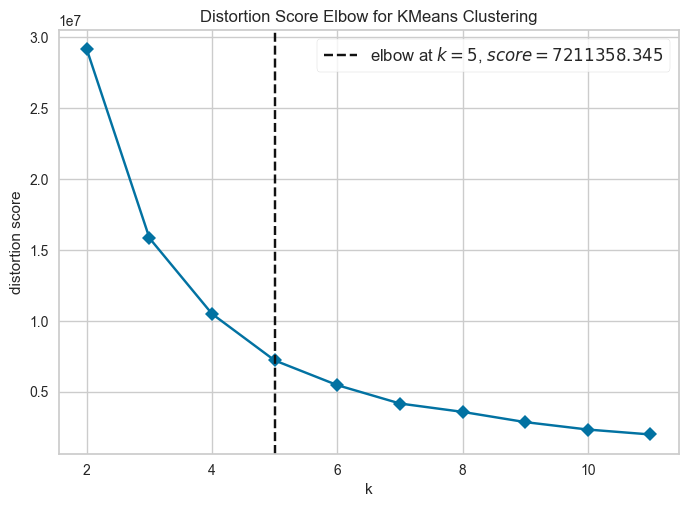

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 2  | elbow score: 0.575


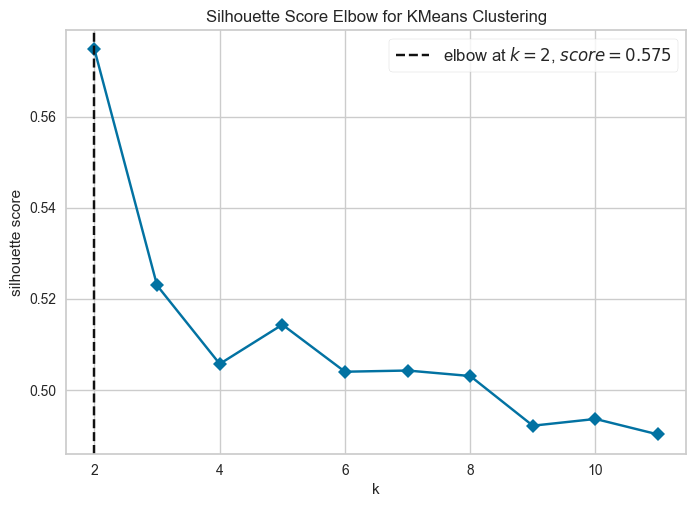

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 7  | elbow score: 69,546.952


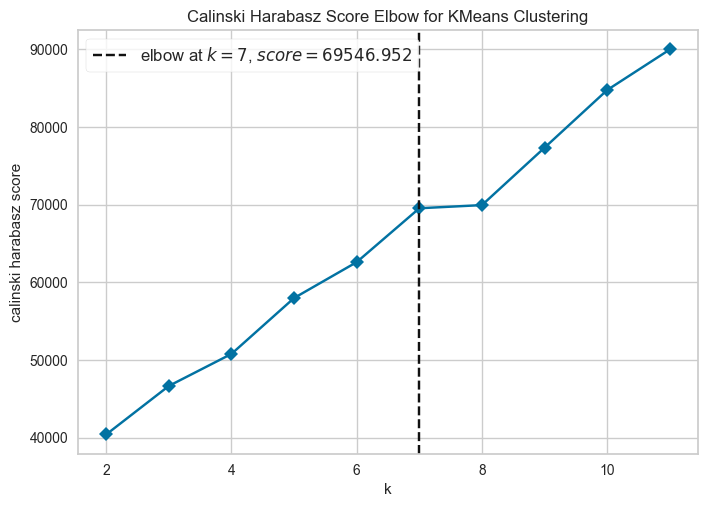

In [4]:
# elbow score plot with Yellowbrick
nK = 12    
RNDN = 42    

def elbowplot(df, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2, nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  

# call elbow plot for each of 3 alternative metrics
# distortion = mean sum of squared distances to center
# silhouette = mean ratio of intra-cluster and nearest-cluster distance
# calinski = ratio of within to between cluster dispersion

model = KMeans(random_state=RNDN)
_ = [elbowplot(X, m, model) for m in ["distortion", "silhouette", "calinski_harabasz"]]


## Clustering Jerárquico

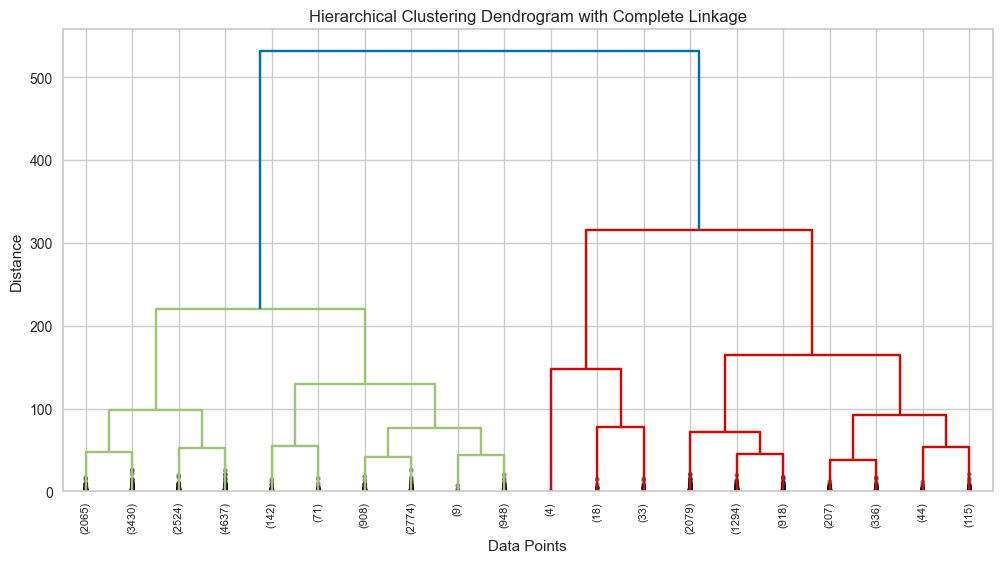

In [5]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering with complete linkage
linkage_matrix = linkage(X, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=8., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

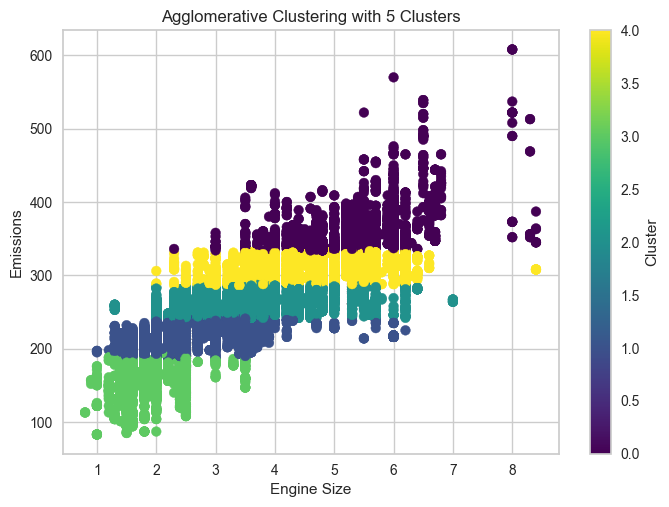

In [6]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
# Create an Agglomerative Clustering model
agg_cluster = AgglomerativeClustering(n_clusters=5)

# Fit the model to the data and get cluster labels
cluster_labels = agg_cluster.fit_predict(X)

# Plot the data with cluster labels
plt.scatter(X[:, 0], X[:, -1], c=cluster_labels, cmap='viridis')
plt.title(f'Agglomerative Clustering with {5} Clusters')
plt.xlabel('Engine Size')
plt.ylabel('Emissions')  # Update the y-axis label to indicate the last column
plt.colorbar(label='Cluster')
plt.show()

El coeficiente de silueta promedio para 5 clusters es: 0.4987773370040373


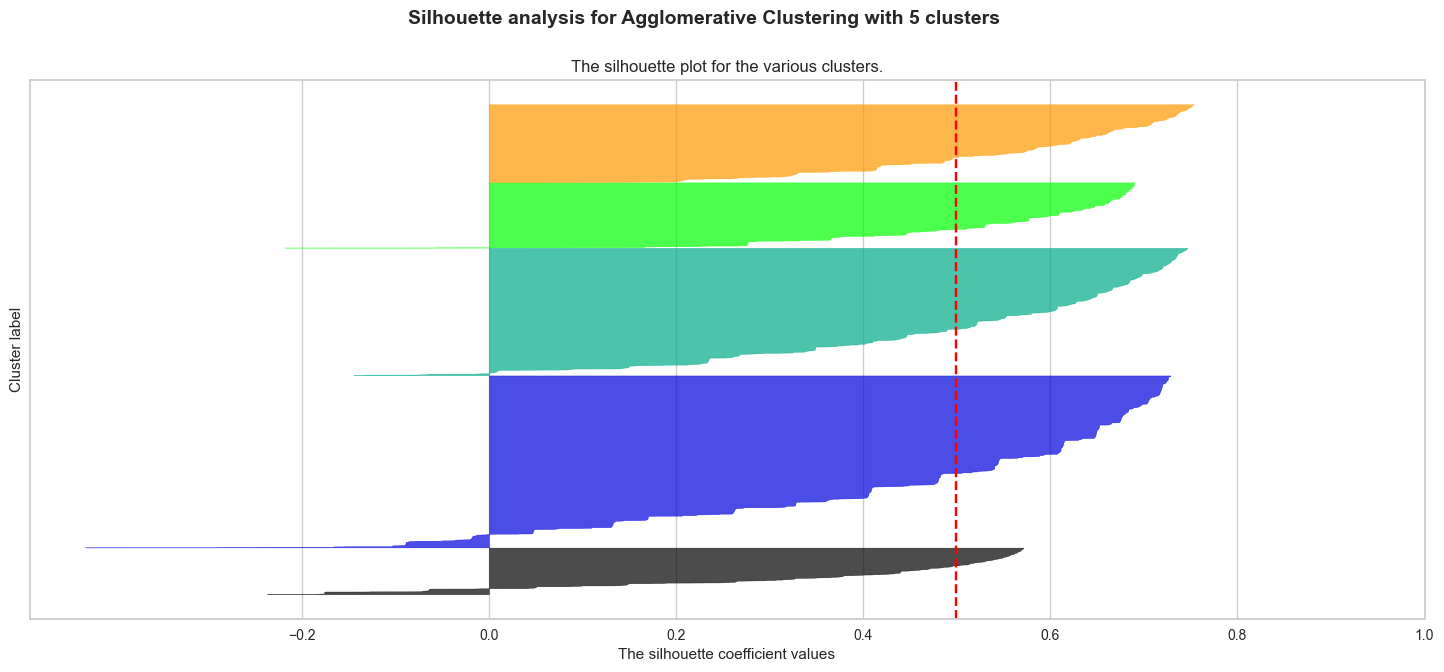

In [7]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm


silhouette_avg = silhouette_score(X, cluster_labels)
print(f"El coeficiente de silueta promedio para {5} clusters es: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(X, cluster_labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

y_lower = 10
for i in range(5):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 5)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")


ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(f"Silhouette analysis for Agglomerative Clustering with {5} clusters",
             fontsize=14, fontweight='bold')

plt.show()


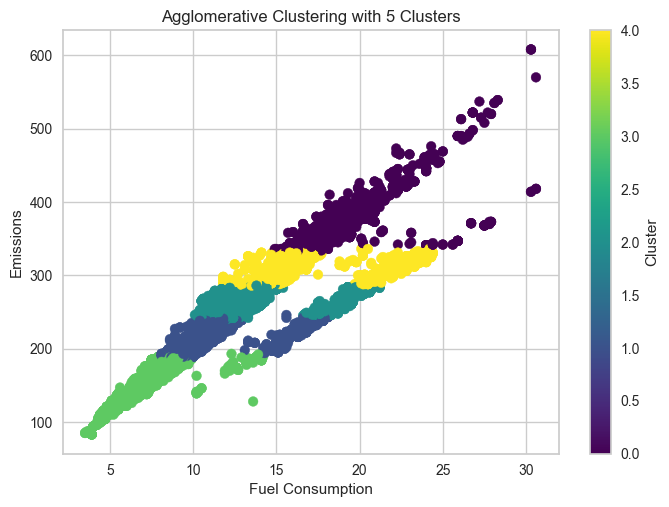

In [8]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
# Create an Agglomerative Clustering model
agg_cluster = AgglomerativeClustering(n_clusters=5)

# Fit the model to the data and get cluster labels
cluster_labels = agg_cluster.fit_predict(X)

# Plot the data with cluster labels
plt.scatter(X[:, 2], X[:, -1], c=cluster_labels, cmap='viridis')
plt.title(f'Agglomerative Clustering with {5} Clusters')
plt.xlabel('Fuel Consumption')
plt.ylabel('Emissions')  # Update the y-axis label to indicate the last column
plt.colorbar(label='Cluster')
plt.show()

El coeficiente de silueta promedio para 5 clusters es: 0.4987773370040373


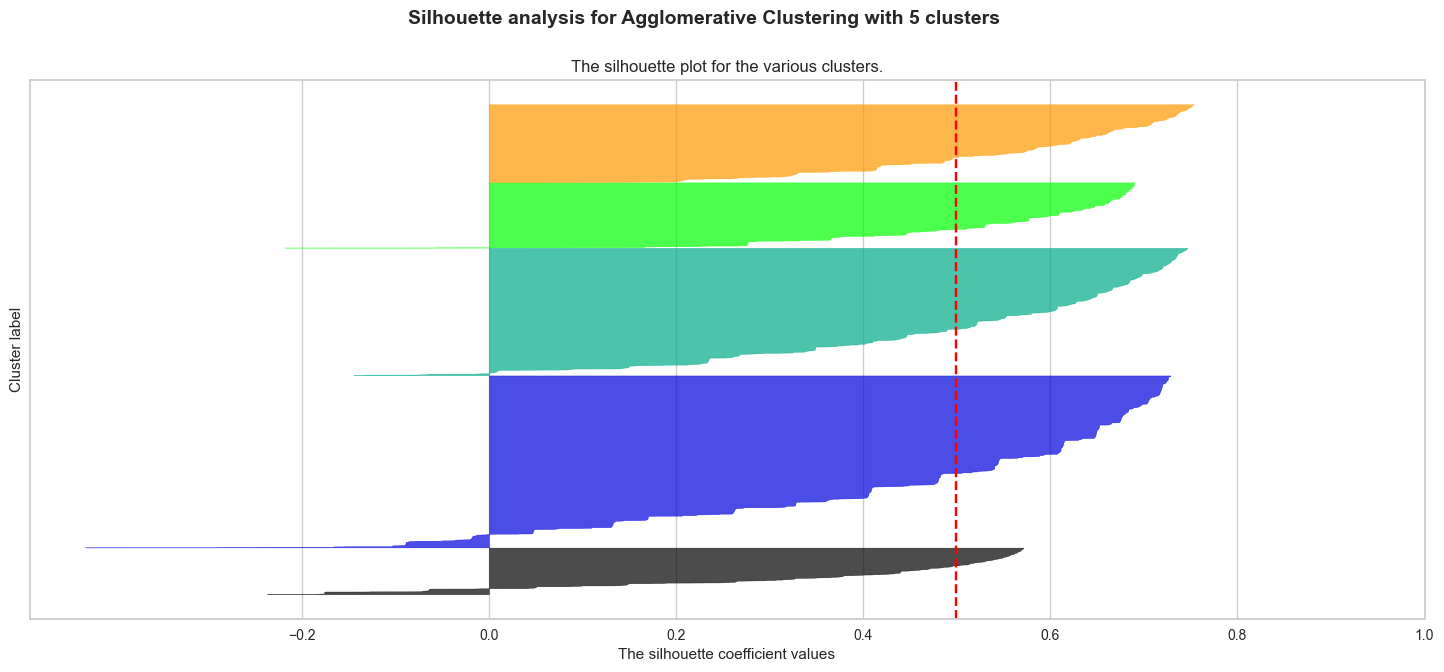

In [9]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm


silhouette_avg = silhouette_score(X, cluster_labels)
print(f"El coeficiente de silueta promedio para {5} clusters es: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(X, cluster_labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

y_lower = 10
for i in range(5):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 5)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")


ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(f"Silhouette analysis for Agglomerative Clustering with {5} clusters",
             fontsize=14, fontweight='bold')

plt.show()

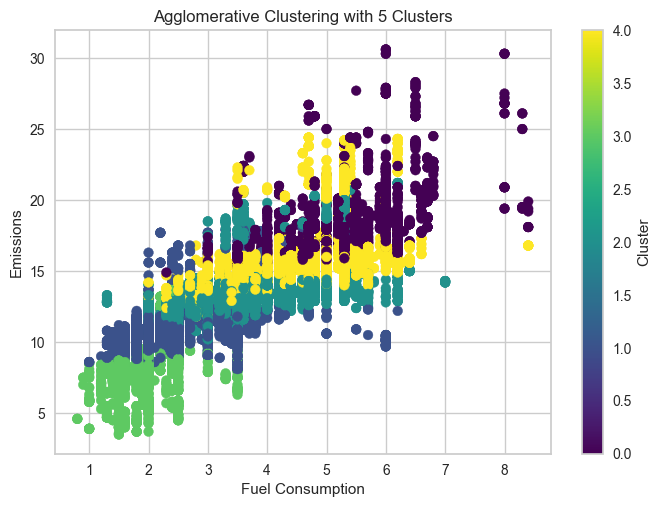

In [43]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
# Create an Agglomerative Clustering model
agg_cluster = AgglomerativeClustering(n_clusters=5)

# Fit the model to the data and get cluster labels
cluster_labels = agg_cluster.fit_predict(X)

# Plot the data with cluster labels
plt.scatter(X[:, 0], X[:, 2], c=cluster_labels, cmap='viridis')
plt.title(f'Agglomerative Clustering with {5} Clusters')
plt.xlabel('Fuel Consumption')
plt.ylabel('Emissions')  # Update the y-axis label to indicate the last column
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm


silhouette_avg = silhouette_score(X, cluster_labels)
print(f"El coeficiente de silueta promedio para {5} clusters es: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(X, cluster_labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

y_lower = 10
for i in range(5):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 5)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")


ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(f"Silhouette analysis for Agglomerative Clustering with {5} clusters",
             fontsize=14, fontweight='bold')

plt.show()

## Fuzzy C-Means

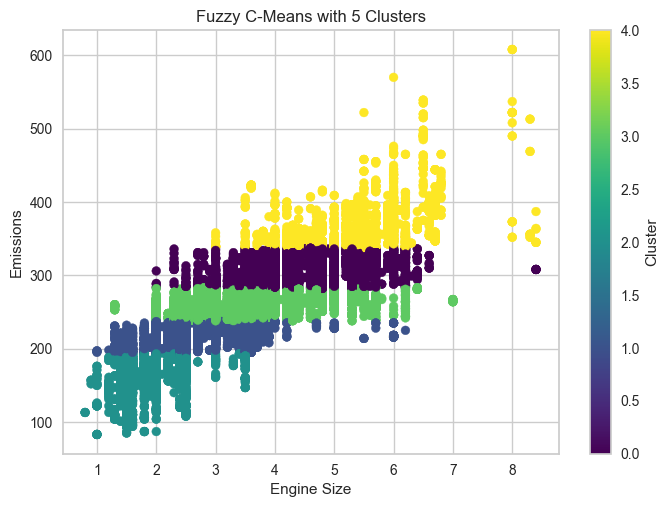

In [50]:
import numpy as np
from fcmeans import FCM # is inside the fuzzy-c-means installation
from matplotlib import pyplot as plt

fcm = FCM(n_clusters=5)
fcm.fit(X)

# outputs
fcm_centers = fcm.centers
fcm_labels = fcm.predict(X)
plt.scatter(X[:, 0], X[:, -1], c=fcm_labels, s=40,cmap="viridis")
plt.title(f'Fuzzy C-Means with {5} Clusters')
plt.xlabel('Engine Size')
plt.ylabel('Emissions')  # Update the y-axis label to indicate the last column
plt.colorbar(label='Cluster')
plt.show()

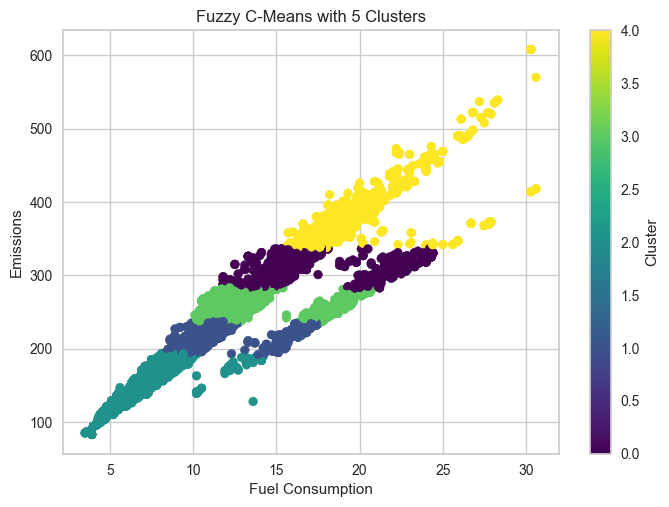

In [51]:
plt.scatter(X[:, 2], X[:, -1], c=fcm_labels, s=40,cmap="viridis")
plt.title(f'Fuzzy C-Means with {5} Clusters')
plt.xlabel('Fuel Consumption')
plt.ylabel('Emissions')  # Update the y-axis label to indicate the last column
plt.colorbar(label='Cluster')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5705698336369217
For n_clusters = 5 The average silhouette_score is : 0.513016433917016
For n_clusters = 7 The average silhouette_score is : 0.498479982515444


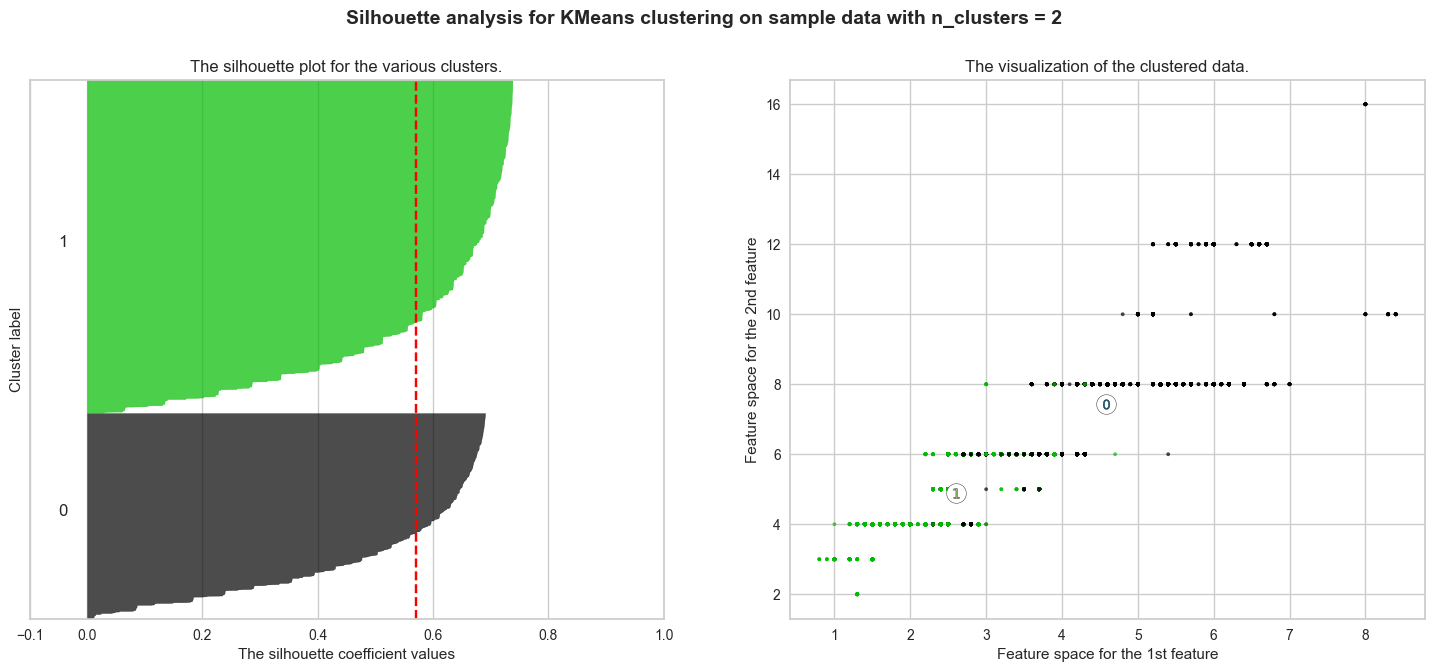

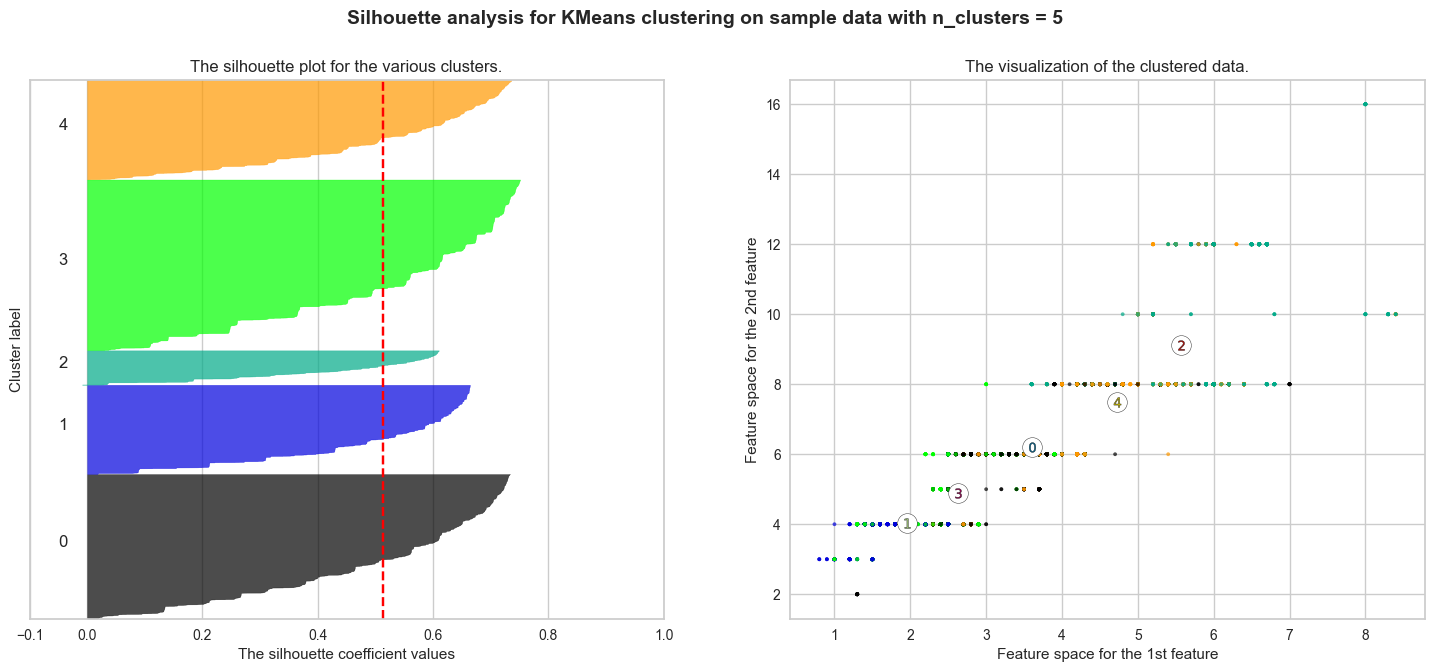

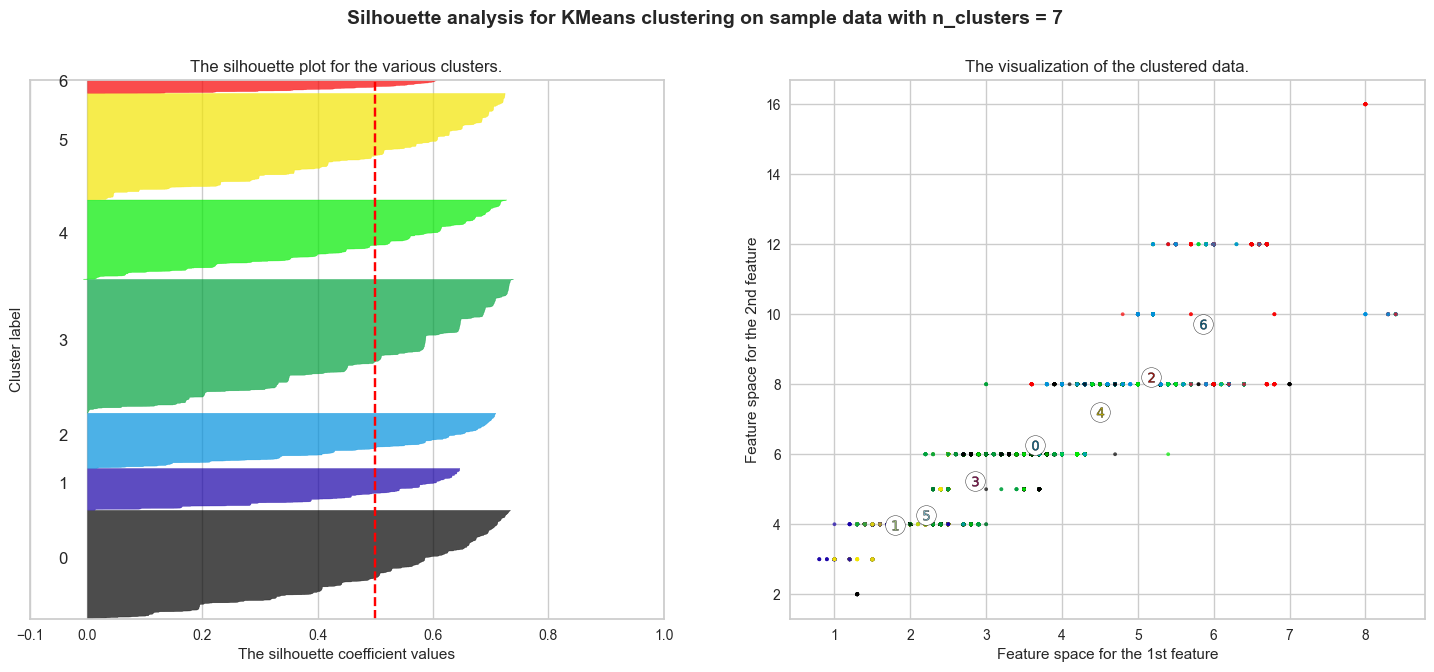

In [19]:
range_n_clusters = [2,5,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

 ## KMedias

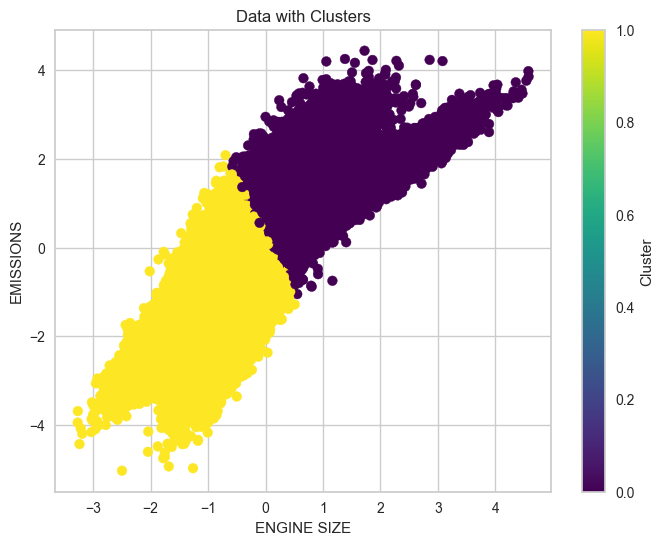

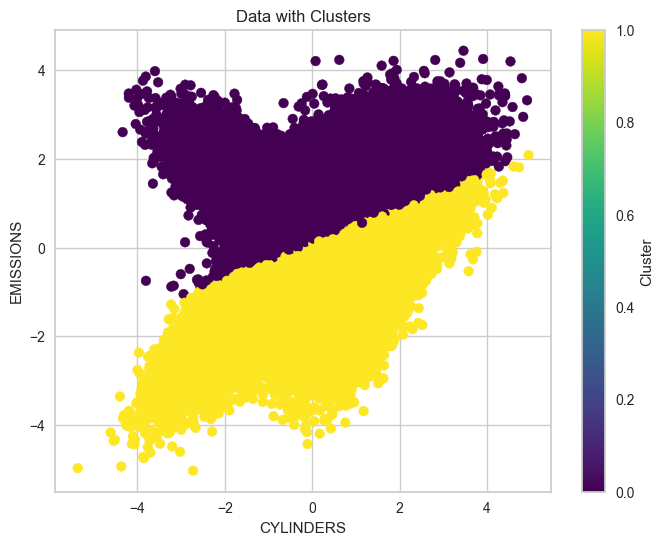

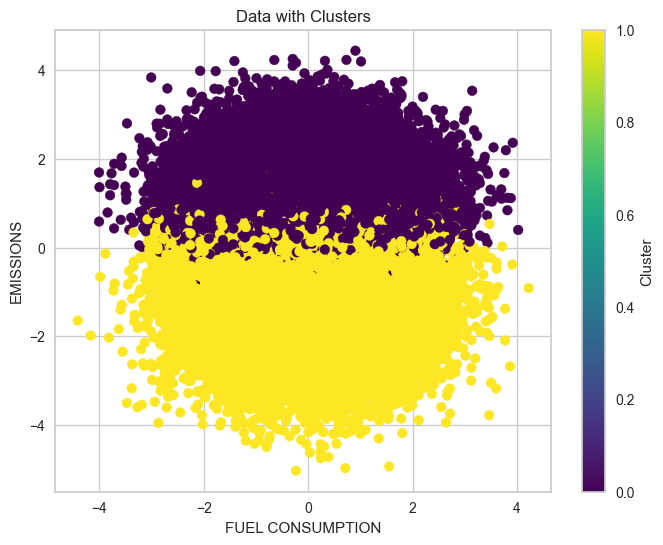

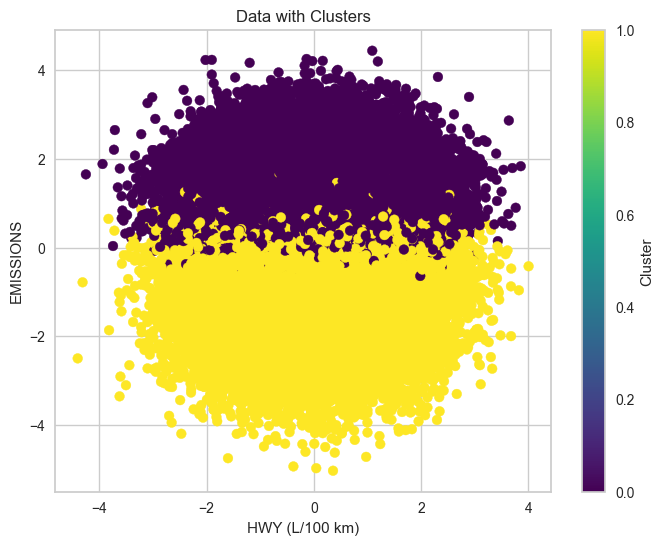

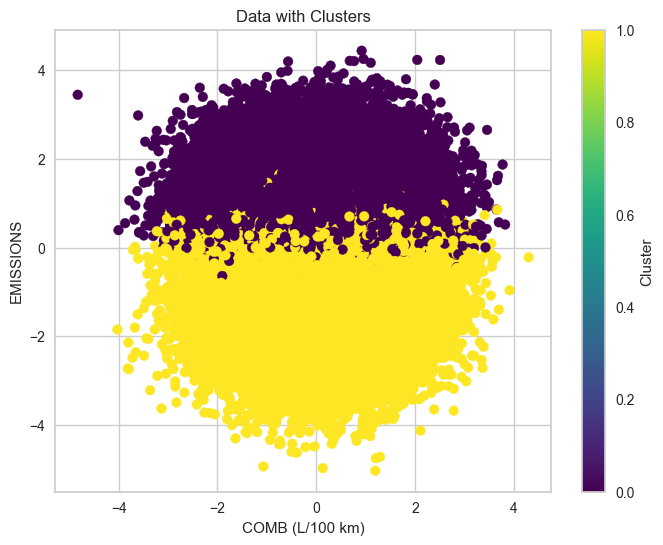

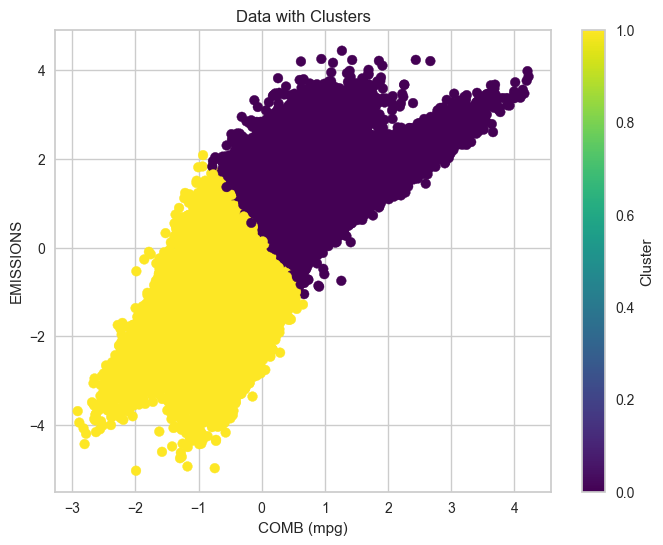

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans

# For 2 clusters
# Generate data
X, y = make_classification(n_samples=100000, n_features=len(columns), random_state=42)

# Create a K-Means clustering model
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the model to your data
cluster_labels = kmeans.fit_predict(X)

for index in range(0, len(columns)-1):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, index], X[:, -1], c=cluster_labels, cmap='viridis')
    plt.xlabel(columns[index])
    plt.ylabel(columns[-1])
    plt.title('Data with Clusters')
    plt.colorbar(label='Cluster')
    plt.show()


El coeficiente de silueta promedio es: 0.24667518011283734


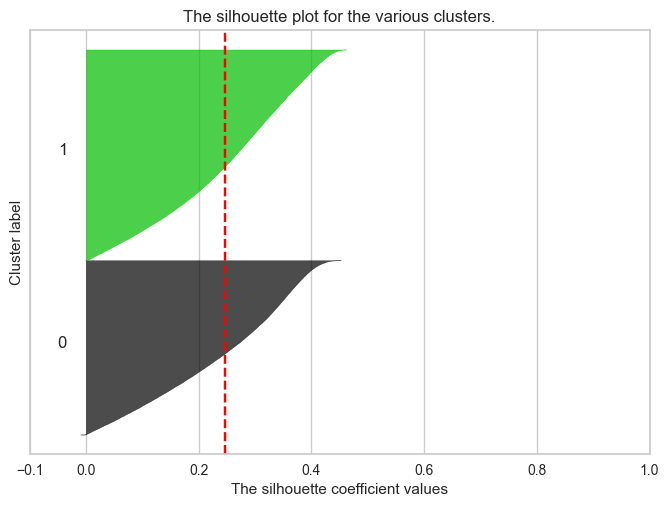

In [12]:
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cluster_labels = kmeans.labels_
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"El coeficiente de silueta promedio es: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(X, cluster_labels)
n_clusters = len(np.unique(cluster_labels))

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

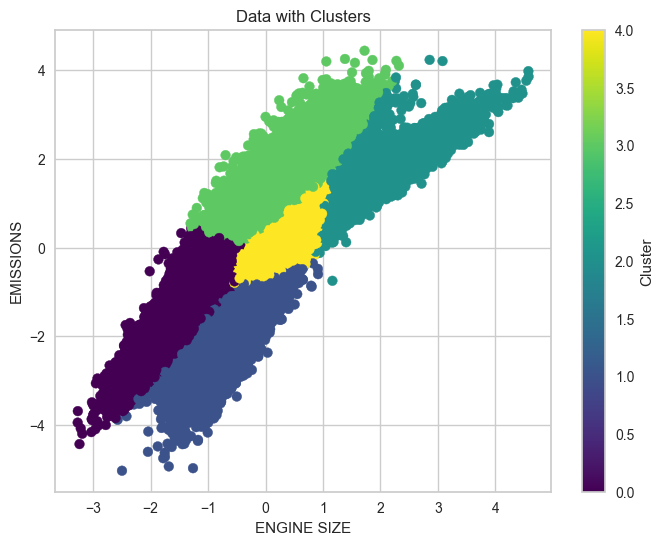

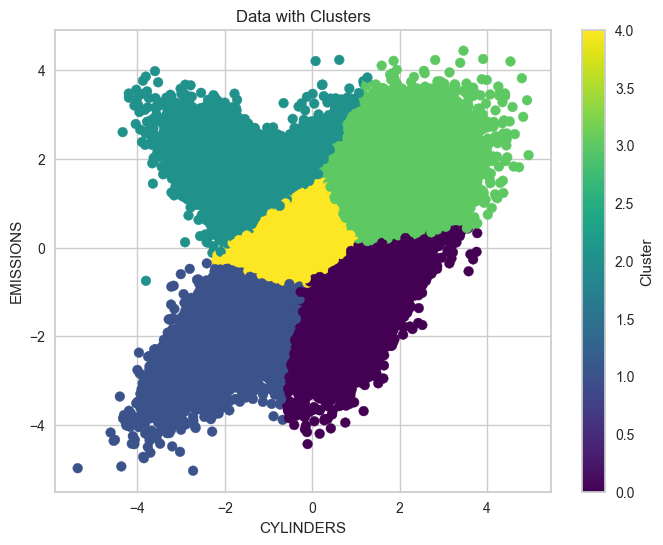

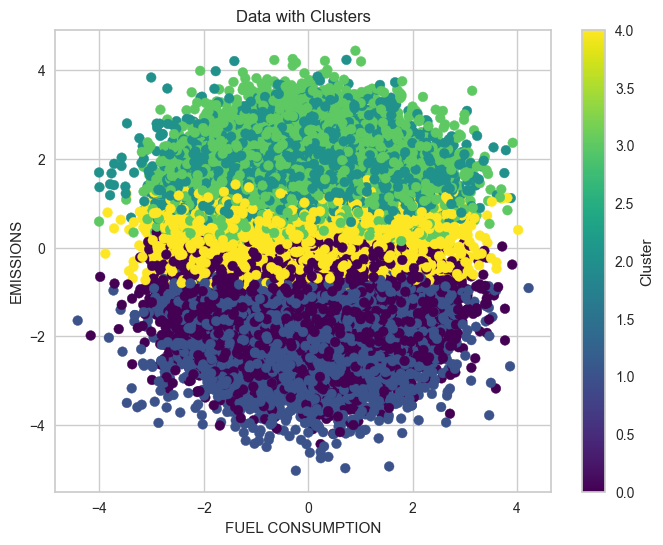

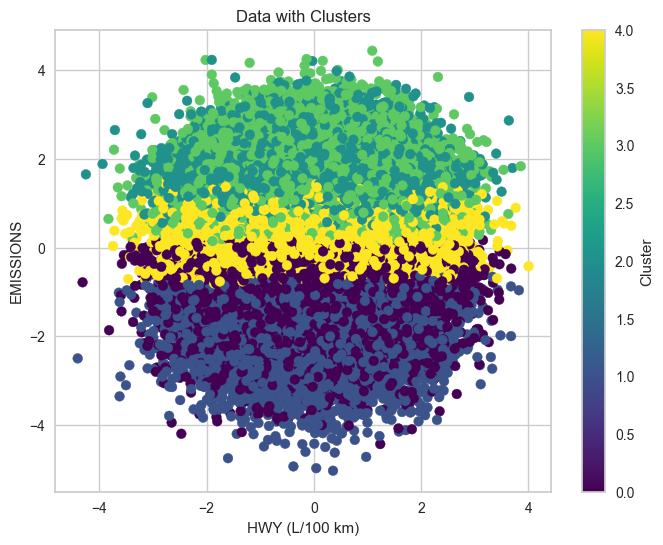

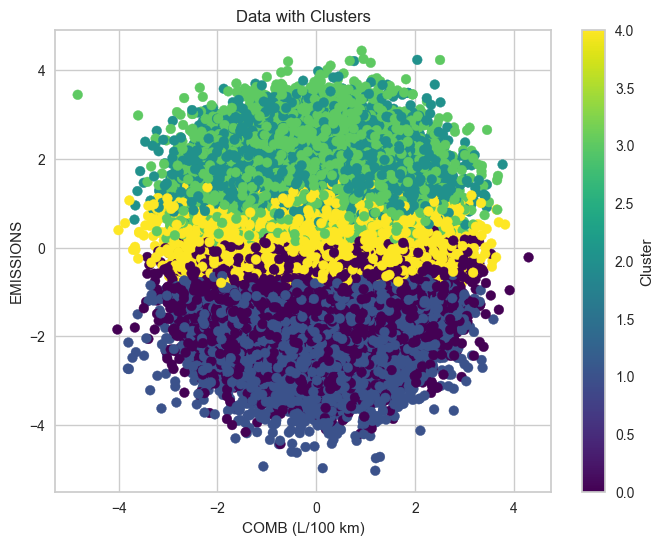

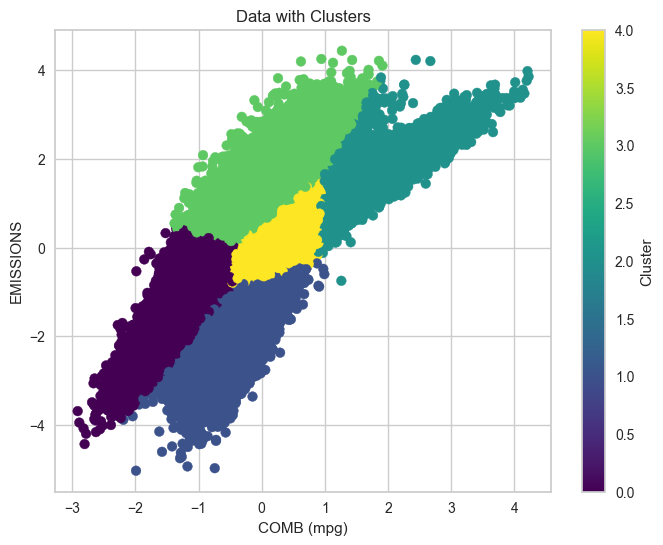

In [103]:
# For 5 clusters
# Generate data
X, y = make_classification(n_samples=100000, n_features=len(columns), random_state=42)

# Create a K-Means clustering model
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the model to your data
cluster_labels = kmeans.fit_predict(X)

for index in range(0, len(columns)-1):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, index], X[:, -1], c=cluster_labels, cmap='viridis')
    plt.xlabel(columns[index])
    plt.ylabel(columns[-1])
    plt.title('Data with Clusters')
    plt.colorbar(label='Cluster')
    plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cluster_labels = kmeans.labels_
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"El coeficiente de silueta promedio es: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(X, cluster_labels)
n_clusters = len(np.unique(cluster_labels))

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

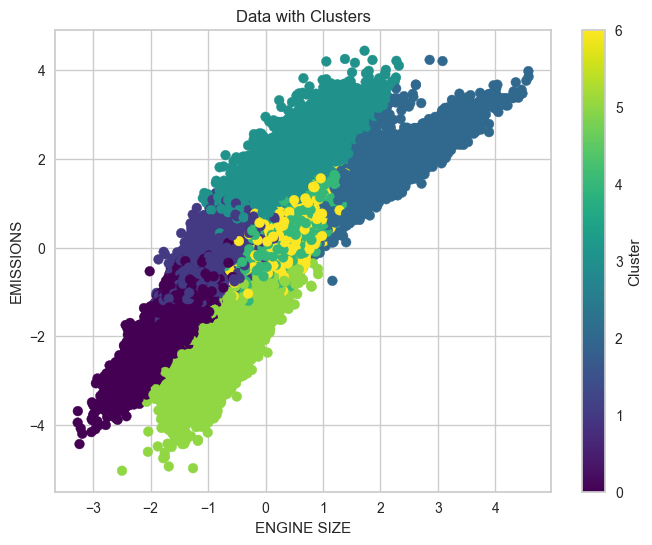

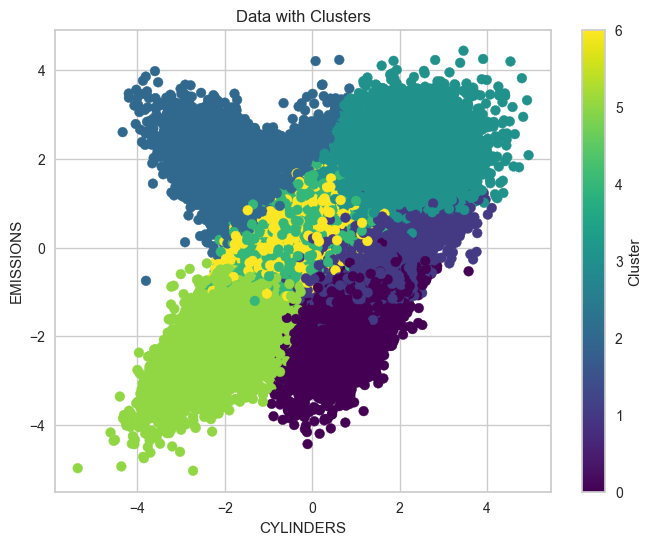

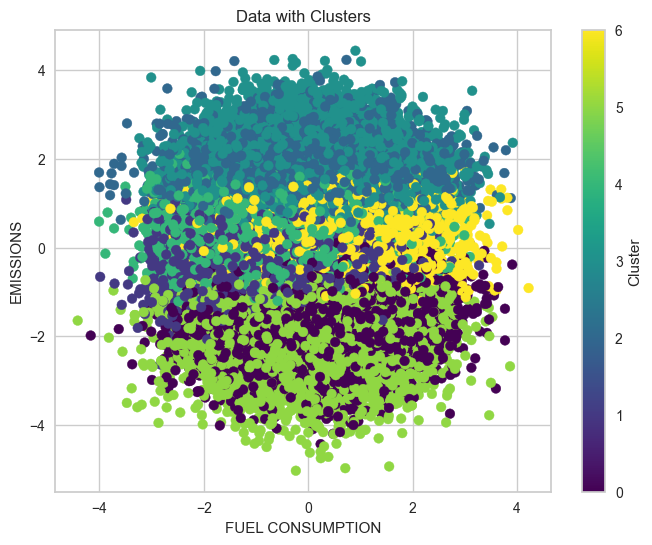

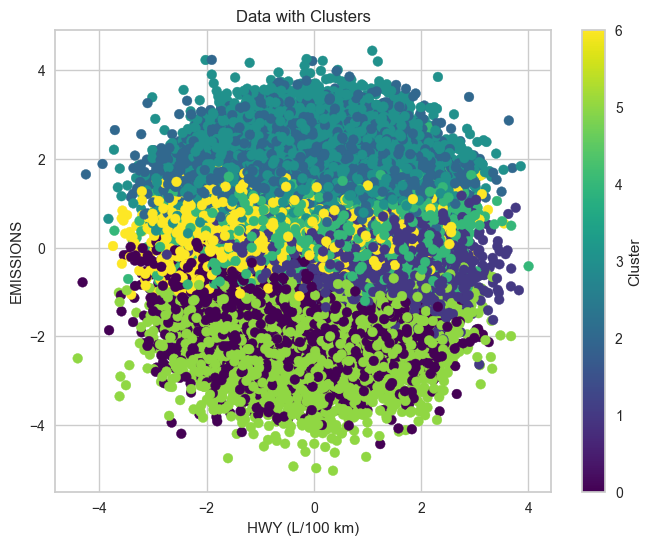

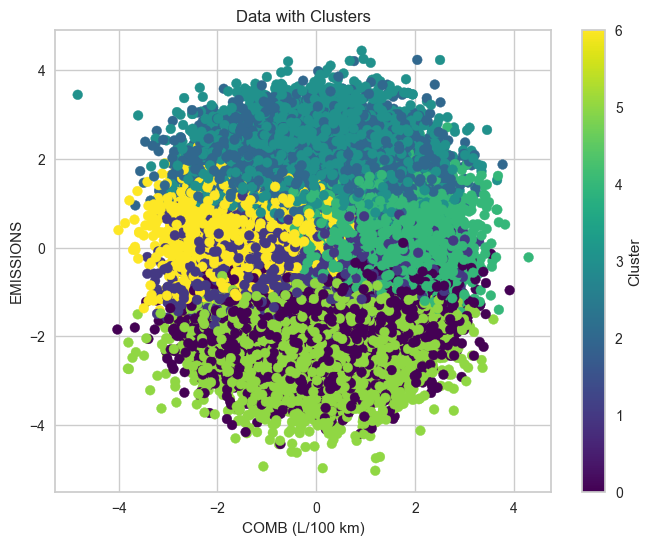

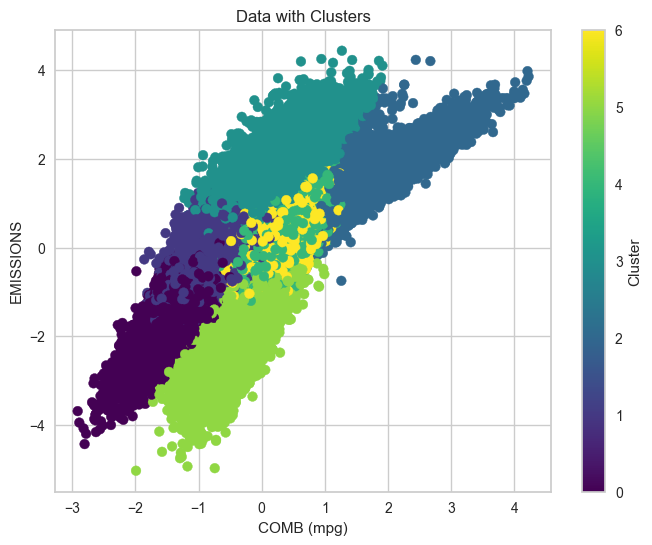

In [104]:
# For 7 clusters
# Generate data
X, y = make_classification(n_samples=100000, n_features=len(columns), random_state=42)

# Create a K-Means clustering model
kmeans = KMeans(n_clusters=7, random_state=42)

# Fit the model to your data
cluster_labels = kmeans.fit_predict(X)

for index in range(0, len(columns)-1):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, index], X[:, -1], c=cluster_labels, cmap='viridis')
    plt.xlabel(columns[index])
    plt.ylabel(columns[-1])
    plt.title('Data with Clusters')
    plt.colorbar(label='Cluster')
    plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cluster_labels = kmeans.labels_
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"El coeficiente de silueta promedio es: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(X, cluster_labels)
n_clusters = len(np.unique(cluster_labels))

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

#### Interpretacion de grupos

Como se pudo observar en los distintos modelos al realizar el clustering de 2, 5 y 7 clusters se llego a evidenciar que los grupos se forman basandose, en la mayor parte, la emision del CO2 con el tamaño del motor, la cantidad de cilindros o el consumo de combustible por lo que se denota que entre mayor sea el motor y mayor cantidad de cilindros tenga junto con mayor consumo, esté llevara a cabo una mayor emisión. Por lo que los grupos se clasificacion de menor a mayor.